In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Подключаем Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Загружаем файл
file_path = '/content/drive/MyDrive/ST14000NM001G.tar'
df = pd.read_csv(file_path)

In [3]:
df.dtypes

,0
date,object
serial_number,object
model,object
capacity_bytes,int64
failure,int64
smart_5_raw,float64
smart_9_raw,float64
smart_187_raw,float64
smart_188_raw,float64
smart_192_raw,float64


In [4]:
# Подсчет уникальных значений по столбцам
unique_counts = df.nunique()

print(unique_counts)

date                  828
serial_number       10927
model                   1
capacity_bytes          1
failure                 2
smart_5_raw          1708
smart_9_raw         20416
smart_187_raw         258
smart_188_raw        2364
smart_192_raw          69
smart_197_raw         485
smart_198_raw         485
smart_199_raw         275
smart_240_raw       20004
smart_241_raw     7283587
smart_242_raw     7293312
dtype: int64


Как видно из вывода, у нас имеются данные о 10927 дисках, столбцы model, capacity_bytes имеют 1 уникальное значение, можно удалить их и датасета

In [5]:
df = df.drop(['model', 'capacity_bytes'], axis=1)

In [6]:
df['date'] = pd.to_datetime(df['date'])
df['serial_number'] = df['serial_number'].astype("string")

In [7]:
counts = df['failure'].value_counts()
print(counts)

failure
0    7319970
1        172
Name: count, dtype: int64


Существует дисбаланс между классами

<Axes: xlabel='count', ylabel='Count'>

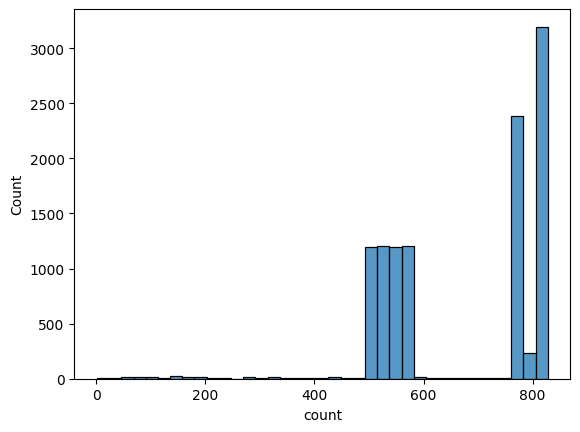

In [8]:
counts = df['serial_number'].value_counts()
sns.histplot(counts)

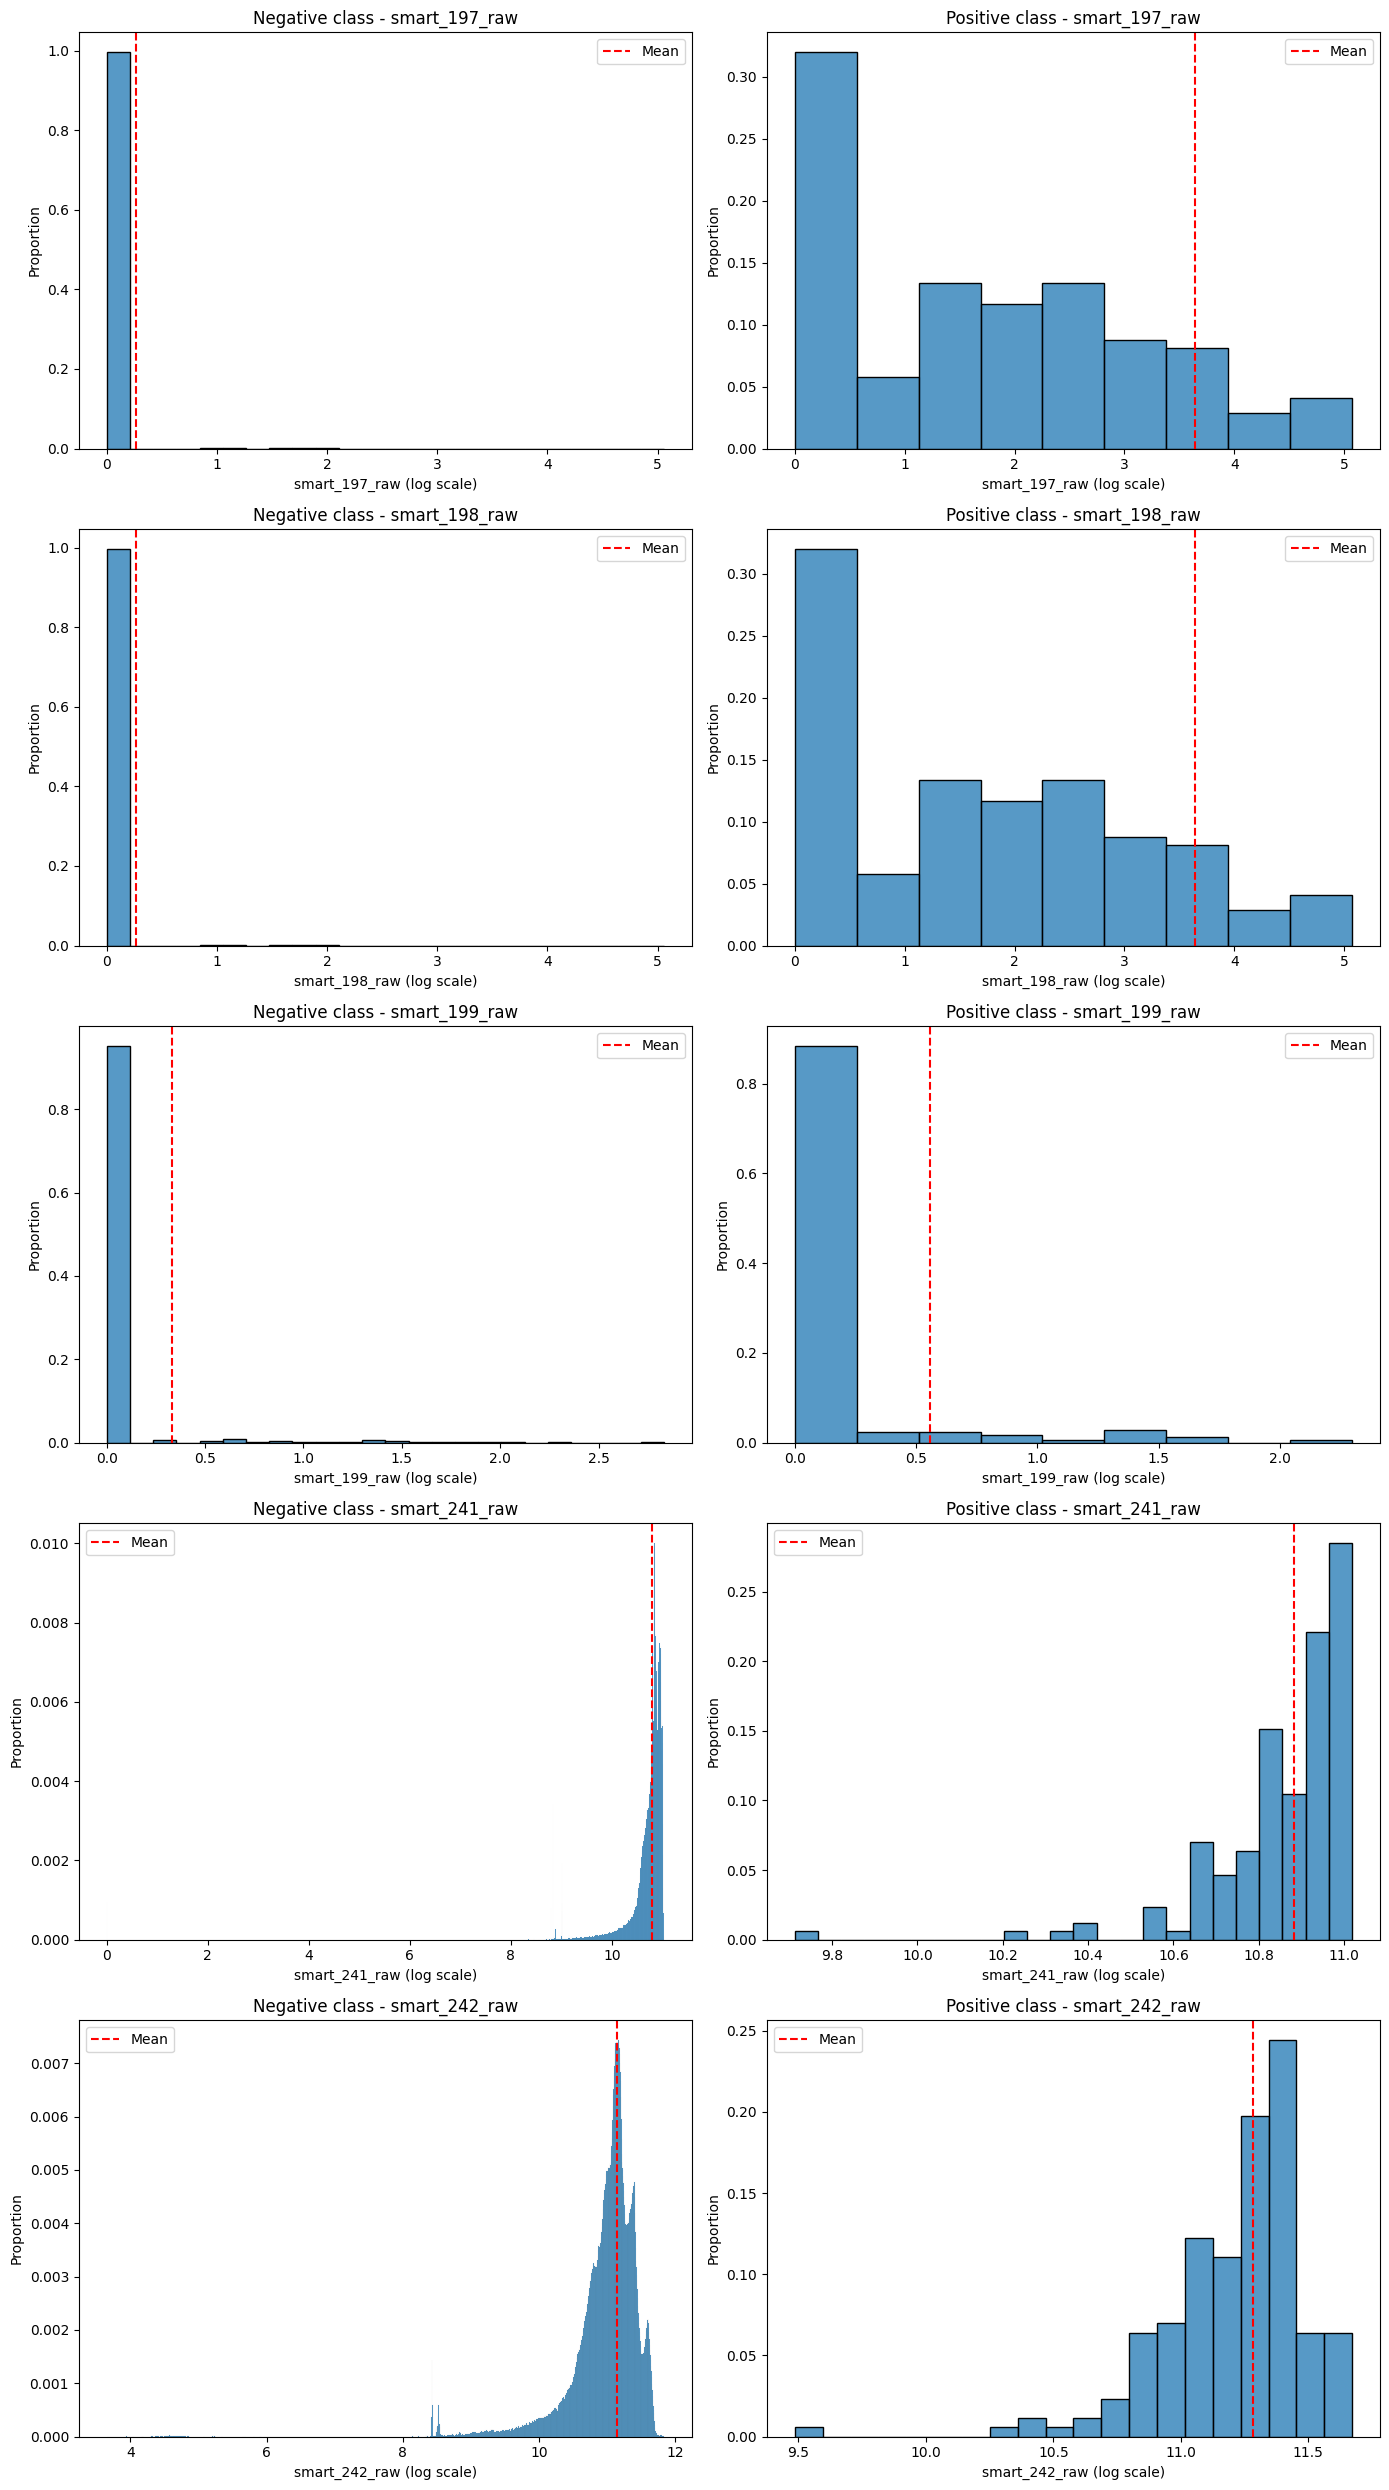

In [9]:
features = ['smart_197_raw', 'smart_198_raw', 'smart_199_raw', 'smart_241_raw', 'smart_242_raw']
target = 'failure'

# Настройка графиков
fig, axs = plt.subplots(len(features), 2, figsize=(14, 5*len(features)))

# Построение графиков для каждого признака
for i, feature in enumerate(features):
    for j, label in enumerate([0, 1]):
        subset = df[df[target] == label]
        ax = sns.histplot(np.log10(subset[feature] + 1), kde=False, ax=axs[i][j], stat='probability')
        ax.axvline(np.log10(subset[feature].mean() + 1), color='r', linestyle='--', label='Mean')

        if j == 0:
            axs[i][j].set_title(f'Negative class - {feature}')
        else:
            axs[i][j].set_title(f'Positive class - {feature}')

        axs[i][j].set(xlabel=f'{feature} (log scale)', ylabel='Proportion')
        axs[i][j].legend()

plt.tight_layout()
plt.show()

In [10]:
difference = df['smart_197_raw'] - df['smart_198_raw']
print(difference.value_counts())

0.0    7320142
Name: count, dtype: int64


Из вывода ясно, что значения столбцов smart_197 и smart_198 одинаковы

In [11]:
del df['smart_197_raw']

## Нормализация

In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [13]:
features = ['smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_188_raw', 'smart_192_raw', 'smart_198_raw', 'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw']
# Z-Score Normalization
scaler_z = StandardScaler()
df[features] = scaler_z.fit_transform(df[features])
df.head()

,date,serial_number,failure,smart_5_raw,smart_9_raw,smart_187_raw,smart_188_raw,smart_192_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
0,2020-11-14,ZL201VZX,0,-0.018321,-1.681505,-0.012435,-0.159261,-0.031235,-0.005951,-0.07988,-1.611073,-2.515577,-1.391211
1,2020-11-15,ZL201VZX,0,-0.018321,-1.675405,-0.012435,-0.159261,-0.031235,-0.005951,-0.07988,-1.611073,-2.515577,-1.391211
2,2020-11-16,ZL201VZX,0,-0.018321,-1.672546,-0.012435,-0.159261,-0.031235,-0.005951,-0.07988,-1.611073,-2.515577,-1.391211
3,2020-11-17,ZL201VZX,0,-0.018321,-1.669687,-0.012435,-0.159261,-0.031235,-0.005951,-0.07988,-1.611073,-2.515577,-1.391211
4,2020-11-18,ZL201VZX,0,-0.018321,-1.663588,-0.012435,-0.159261,-0.031235,-0.005951,-0.07988,-1.611073,-2.515577,-1.391211


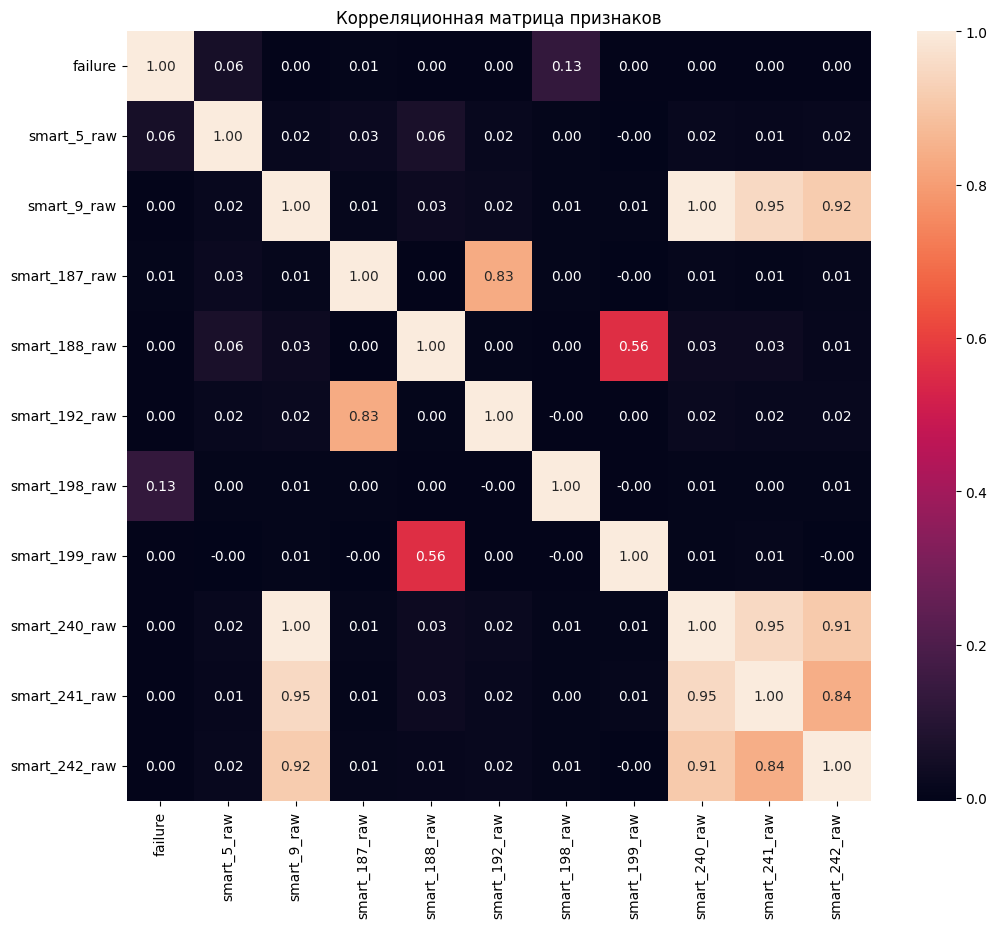

In [14]:
# Корреляционная матрица
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.title('Корреляционная матрица признаков')
plt.show()

Из Корреляционной матрицы видна сильная зависимость следующих признаков


*   smart_192 и smart_187: 0.83
*   smart_240 и smart_241: 0.95
*   smart_241 и smart_242: 0.84
*   smart_242 и smart_240: 0.91
*   smart_240 и smart_9: 1.00
*   smart_9 и smart_241: 0.95
*   smart_242 и smart_9: 0.92



Уменьшим размерность объединив коррелирующие фичи


*   smart_192 и smart_187  --> new_smart_1
*   smart_9, smart_242, smart_241, smart_240 --> new_smart_2



In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)  # Мы хотим получить один компонент

In [16]:
df_small = df.copy()
df_small['new_smart_1'] = pca.fit_transform(df_small[['smart_192_raw', 'smart_187_raw']])
df_small['new_smart_2'] = pca.fit_transform(df_small[['smart_9_raw', 'smart_242_raw', 'smart_241_raw', 'smart_240_raw']])

In [17]:
df_small = df_small.drop(['smart_192_raw', 'smart_187_raw', 'smart_9_raw', 'smart_242_raw', 'smart_241_raw', 'smart_240_raw'], axis=1)

## Балансировка

Возьмем медианные значение по неделям для failure = 0, для уменьшения класса

In [18]:
import datetime

def func(group):
  group.iloc[[0], 0] = group.iloc[[0], 0]+datetime.timedelta(days=6*1)
  return group

df_true = df_small[df_small['failure'] == 1]
df_false = df_small[df_small['failure'] == 0]

week_df_true = df_true.groupby('serial_number').apply(func).reset_index(drop=True)

week_df_false = (
    df_false.groupby('serial_number')
      .resample('7D', on='date')  # Сжимаем данные по неделям
      .median()                   # Берем медиану
      .reset_index()              # Сбрасываем индексы для удобства
)

<ipython-input-18-083bb617dfcd>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  week_df_true = df_true.groupby('serial_number').apply(func).reset_index(drop=True)


In [19]:
def f(group):
  group = group.sort_values(by='date')
  if group.iloc[len(group) - 1]['failure'] == 1:
    group.loc[group.index[-4:], 'failure'] = 1
  return group

df_combined = pd.concat([week_df_true, week_df_false]).sample(frac=1)
df_combined = df_combined.groupby('serial_number').apply(f).reset_index(drop=True)

<ipython-input-19-265f1daf08a9>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_combined = df_combined.groupby('serial_number').apply(f).reset_index(drop=True)


In [20]:
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split

Расширение малого класса

In [21]:
df_combined = df_combined.dropna()

In [22]:
print(df_combined.isnull().sum())

date             0
serial_number    0
failure          0
smart_5_raw      0
smart_188_raw    0
smart_198_raw    0
smart_199_raw    0
new_smart_1      0
new_smart_2      0
dtype: int64


In [24]:
adasyn = ADASYN(sampling_strategy=0.3, random_state=42)

# Выбор признаков и целевого столбца
small_features = ['smart_5_raw', 'smart_188_raw', 'smart_198_raw', 'smart_199_raw', 'new_smart_1', 'new_smart_2']

X = df_combined[small_features]
y = df_combined['failure']

# Разделяем данные на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_train, y_train)

In [77]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, classification_report
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier

In [25]:

# Инициализация и обучение модели XGBoost
xgboost_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=5)
xgboost_model.fit(X_resampled_adasyn, y_resampled_adasyn)

# Предсказание
xgboost_predictions = xgboost_model.predict(X_test)

In [27]:

# Классификация фактических значений
y_test_class = (y_test > 0.5).astype(int)

# Классификация предсказанных значений
xgboost_predictions_class = (xgboost_predictions > 0.5).astype(int)

print("XGBoost Classification Report:")
print(classification_report(y_test_class, xgboost_predictions_class))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213021
           1       0.20      0.76      0.31       145

    accuracy                           1.00    213166
   macro avg       0.60      0.88      0.65    213166
weighted avg       1.00      1.00      1.00    213166



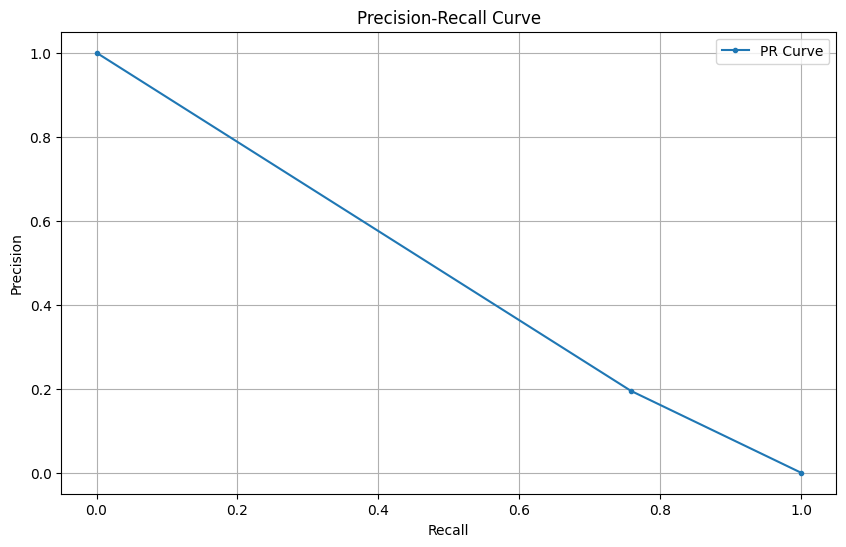

PR AUC: 0.47708338185679194


In [31]:
# Вычисление Precision и Recall
precision, recall, _ = precision_recall_curve(y_test_class, xgboost_predictions_class)

# Построение PR-кривой
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

# Вычисление AUC для PR-кривой
pr_auc = auc(recall, precision)
print(f'PR AUC: {pr_auc}')

In [33]:
!pip install catboost

In [51]:
# Инициализация и обучение модели CatBoost
catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=10, verbose=50)
catboost_model.fit(X_train, y_train)

# Предсказание
catboost_predictions = catboost_model.predict(X_test)

0:	learn: 0.0246596	total: 335ms	remaining: 5m 35s
100:	learn: 0.0176010	total: 21.7s	remaining: 3m 13s
200:	learn: 0.0162915	total: 47s	remaining: 3m 6s
300:	learn: 0.0154906	total: 1m 11s	remaining: 2m 46s
400:	learn: 0.0149198	total: 1m 32s	remaining: 2m 18s
500:	learn: 0.0145516	total: 1m 53s	remaining: 1m 53s
600:	learn: 0.0141037	total: 2m 15s	remaining: 1m 30s
700:	learn: 0.0137395	total: 2m 36s	remaining: 1m 6s
800:	learn: 0.0135471	total: 2m 59s	remaining: 44.6s
900:	learn: 0.0133412	total: 3m 21s	remaining: 22.1s
999:	learn: 0.0130740	total: 3m 44s	remaining: 0us


In [74]:
# Классификация предсказанных значений
catboost_predictions_1 = (catboost_predictions > 0.4).astype(int)

print("CatBoost Classification Report:")
print(classification_report(y_test_class, catboost_predictions_1))

CatBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213021
           1       0.81      0.63      0.71       145

    accuracy                           1.00    213166
   macro avg       0.90      0.81      0.85    213166
weighted avg       1.00      1.00      1.00    213166



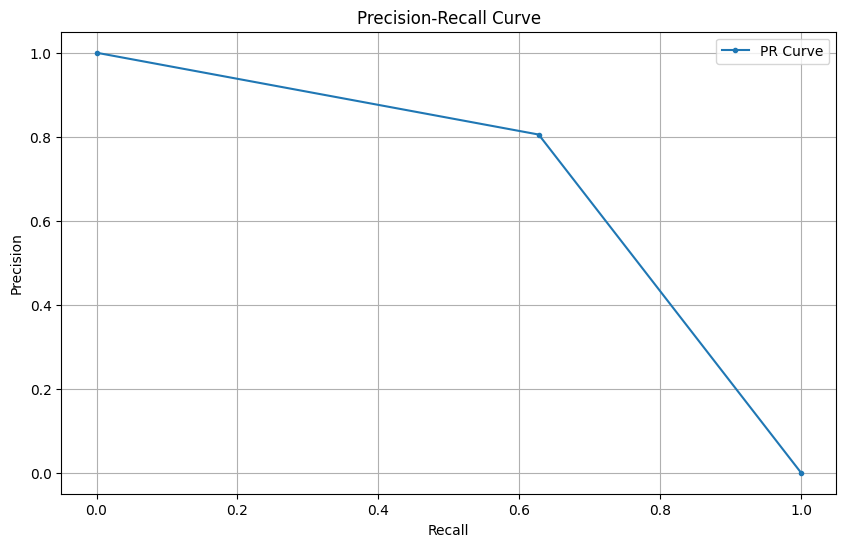

PR AUC: 0.716574632555302


In [75]:
# Вычисление Precision и Recall
precision, recall, _ = precision_recall_curve(y_test_class, catboost_predictions_1)

# Построение PR-кривой
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

# Вычисление AUC для PR-кривой
pr_auc = auc(recall, precision)
print(f'PR AUC: {pr_auc}')

In [ ]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Предсказания и оценка
rf_pred = rf_model.predict(X_test)

In [84]:
print("Random Forest Classification Report")
print(classification_report(y_test, rf_pred))

Random Forest Classification Report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    213021
         1.0       0.62      0.48      0.54       145

    accuracy                           1.00    213166
   macro avg       0.81      0.74      0.77    213166
weighted avg       1.00      1.00      1.00    213166



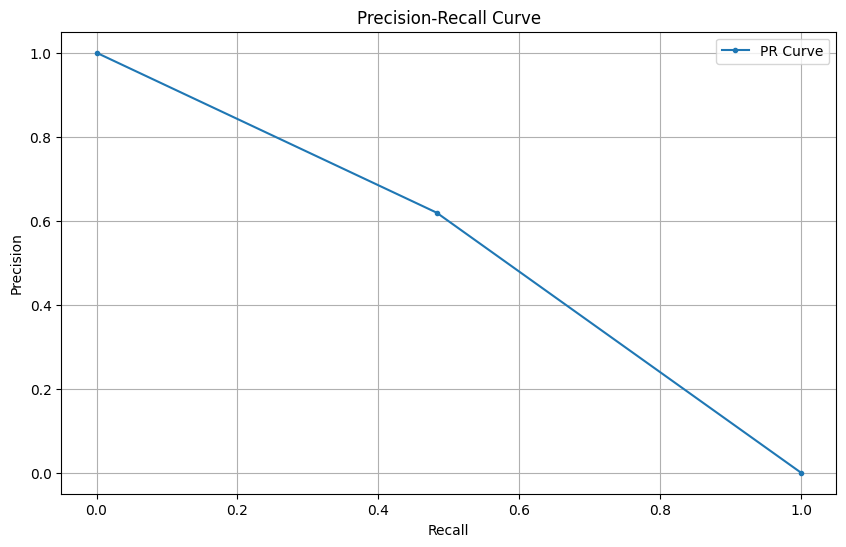

PR AUC: 0.5512897428558151


In [85]:

# Вычисление Precision и Recall
precision, recall, _ = precision_recall_curve(y_test_class, rf_pred)

# Построение PR-кривой
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.', label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

# Вычисление AUC для PR-кривой
pr_auc = auc(recall, precision)
print(f'PR AUC: {pr_auc}')

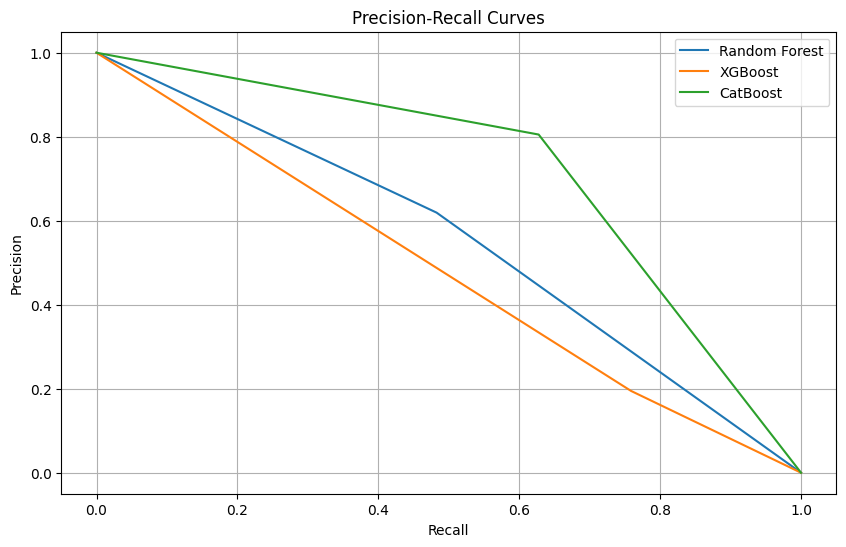

In [88]:
# Вычисляем кривые для всех моделей
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_pred)
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgboost_predictions_class )
cat_precision, cat_recall, _ = precision_recall_curve(y_test, catboost_predictions_1)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(rf_recall, rf_precision, label='Random Forest')
plt.plot(xgb_recall, xgb_precision, label='XGBoost')
plt.plot(cat_recall, cat_precision, label='CatBoost')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.grid()
plt.show()

In [89]:
from sklearn.metrics import roc_auc_score

In [90]:
# Считаем ROC-AUC для всех моделей
print(f"Random Forest ROC-AUC: {roc_auc_score(y_test, rf_pred):.4f}")
print(f"XGBoost ROC-AUC: {roc_auc_score(y_test, xgboost_predictions_class):.4f}")
print(f"CatBoost ROC-AUC: {roc_auc_score(y_test, catboost_predictions_1):.4f}")

Random Forest ROC-AUC: 0.7413
XGBoost ROC-AUC: 0.8782
CatBoost ROC-AUC: 0.8137
